In [2]:
# import keras
# from keras import layers
# from keras import backend as K
# from keras.models import Model
# keras.__version__

In [3]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [4]:
#tf.config.experimental_run_functions_eagerly(True)
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
#InteractiveSession.close()
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [6]:

from tensorflow.keras import backend as K
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model

In [7]:
#from keras import backend as K
K.clear_session()

# Generating images

This notebook contains the second code sample found in Chapter 8, Section 4 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---


## Variational autoencoders


Variational autoencoders, simultaneously discovered by Kingma & Welling in December 2013, and Rezende, Mohamed & Wierstra in January 2014, 
are a kind of generative model that is especially appropriate for the task of image editing via concept vectors. They are a modern take on 
autoencoders -- a type of network that aims to "encode" an input to a low-dimensional latent space then "decode" it back -- that mixes ideas 
from deep learning with Bayesian inference.

A classical image autoencoder takes an image, maps it to a latent vector space via an "encoder" module, then decode it back to an output 
with the same dimensions as the original image, via a "decoder" module. It is then trained by using as target data the _same images_ as the 
input images, meaning that the autoencoder learns to reconstruct the original inputs. By imposing various constraints on the "code", i.e. 
the output of the encoder, one can get the autoencoder to learn more or less interesting latent representations of the data. Most 
commonly, one would constraint the code to be very low-dimensional and sparse (i.e. mostly zeros), in which case the encoder acts as a way 
to compress the input data into fewer bits of information.

![Autoencoder](https://s3.amazonaws.com/book.keras.io/img/ch8/autoencoder.jpg)


In practice, such classical autoencoders don't lead to particularly useful or well-structured latent spaces. They're not particularly good 
at compression, either. For these reasons, they have largely fallen out of fashion over the past years. Variational autoencoders, however, 
augment autoencoders with a little bit of statistical magic that forces them to learn continuous, highly structured latent spaces. They 
have turned out to be a very powerful tool for image generation.

A VAE, instead of compressing its input image into a fixed "code" in the latent space, turns the image into the parameters of a statistical 
distribution: a mean and a variance. Essentially, this means that we are assuming that the input image has been generated by a statistical 
process, and that the randomness of this process should be taken into accounting during encoding and decoding. The VAE then uses the mean 
and variance parameters to randomly sample one element of the distribution, and decodes that element back to the original input. The 
stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere, i.e. every 
point sampled in the latent will be decoded to a valid output.

![VAE](https://s3.amazonaws.com/book.keras.io/img/ch8/vae.png)


In technical terms, here is how a variational autoencoder works. First, an encoder module turns the input samples `input_img` into two 
parameters in a latent space of representations, which we will note `z_mean` and `z_log_variance`. Then, we randomly sample a point `z` 
from the latent normal distribution that is assumed to generate the input image, via `z = z_mean + exp(z_log_variance) * epsilon`, where 
epsilon is a random tensor of small values. Finally, a decoder module will map this point in the latent space back to the original input 
image. Because `epsilon` is random, the process ensures that every point that is close to the latent location where we encoded `input_img` 
(`z-mean`) can be decoded to something similar to `input_img`, thus forcing the latent space to be continuously meaningful. Any two close 
points in the latent space will decode to highly similar images. Continuity, combined with the low dimensionality of the latent space, 
forces every direction in the latent space to encode a meaningful axis of variation of the data, making the latent space very structured 
and thus highly suitable to manipulation via concept vectors.

The parameters of a VAE are trained via two loss functions: first, a reconstruction loss that forces the decoded samples to match the 
initial inputs, and a regularization loss, which helps in learning well-formed latent spaces and reducing overfitting to the training data.

Let's quickly go over a Keras implementation of a VAE. Schematically, it looks like this:

In [8]:
# Encode the input into a mean and variance parameter
# z_mean, z_log_variance = encoder(input_img)

# Draw a latent point using a small random epsilon
# z = z_mean + exp(z_log_variance) * epsilon

# Then decode z back to an image
# reconstructed_img = decoder(z)

# Instantiate a model
# model = Model(input_img, reconstructed_img)

# Then train the model using 2 losses:
# a reconstruction loss and a regularization loss

Here is the encoder network we will use: a very simple convnet which maps the input image `x` to two vectors, `z_mean` and `z_log_variance`.

In [9]:
#import keras
#from keras import layers
#from keras import backend as K
#from keras.models import Model
import numpy as np

img_shape = (128, 128, 1)
batch_size = 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(16, 3, padding='same', activation='relu',strides=2)(input_img)
x = layers.Conv2D(32, 3, padding='same', activation='relu',strides=2)(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu',strides=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(4, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Here is the code for using `z_mean` and `z_log_var`, the parameters of the statistical distribution assumed to have produced `input_img`, to 
generate a latent space point `z`. Here, we wrap some arbitrary code (built on top of Keras backend primitives) into a `Lambda` layer. In 
Keras, everything needs to be a layer, so code that isn't part of a built-in layer should be wrapped in a `Lambda` (or else, in a custom 
layer).

In [10]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [11]:
encoder = keras.Model(input_img, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   4640        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 64)   18496       conv2d_1[0][0]                   
____________________________________________________________________________________________


This is the decoder implementation: we reshape the vector `z` to the dimensions of an image, then we use a few convolution layers to obtain a final 
image output that has the same dimensions as the original `input_img`.

In [12]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(latent_dim)
x = layers.Dense(16*16*64,activation='relu')(decoder_input)
x = layers.Reshape((16,16,64))(x)
x = layers.Conv2DTranspose(64, 3,padding='same', activation='relu',strides=2)(x)
x = layers.Conv2DTranspose(32, 3,padding='same', activation='relu',strides=2)(x)
x = layers.Conv2DTranspose(16, 3,padding='same', activation='relu',strides=2)(x)
#x = layers.Conv2DTranspose(8, 3,padding='same', activation='relu',strides=2)(x)

decoder_outputs = layers.Conv2DTranspose(1,3,activation="sigmoid",padding="same")(x)
decoder = Model(decoder_input, decoder_outputs)
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16384)             49152     
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 16)      4624      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 128, 128, 1)       145   

In [13]:
# We then apply it to `z` to recover the decoded `z`.
# z_decoded = decoder(z)

The dual loss of a VAE doesn't fit the traditional expectation of a sample-wise function of the form `loss(input, target)`. Thus, we set up 
the loss by writing a custom layer with internally leverages the built-in `add_loss` layer method to create an arbitrary loss.

In [14]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder=encoder
        self.decoder=decoder
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28*28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [15]:
# Train the VAE on MNIST digits
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, y_test) = mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)[0:30000]
print(mnist_digits.shape)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
print(mnist_digits.shape)

11493376/11490434 [==============================] - 0s 0us/step
(30000, 28, 28)
(30000, 28, 28, 1)


In [16]:
import cv2
def resizeImage(img, size = 128):
    imgR = np.zeros((img.shape[0],size,size))
    for i in range(img.shape[0]):
        imgR[i] = cv2.resize(img[i],(size,size))
    return(imgR)

In [17]:
mnist_digits = resizeImage(mnist_digits)

In [30]:
import matplotlib.pyplot as plt
def plotImageTransp(file1, k, alpha = 0.2):
    fig, ax = plt.subplots(nrows=k, ncols=k, figsize=(18, 18))
    for i in range(k):
        for j in range(k):
            ind = np.random.randint(0,file1.shape[0]-1)
            ax[i,j].imshow(file1[ind], cmap='Greys')
            ax[i,j].set_axis_off()
    fig.subplots_adjust(wspace = -0.15, hspace = 0.02)
    return(fig)

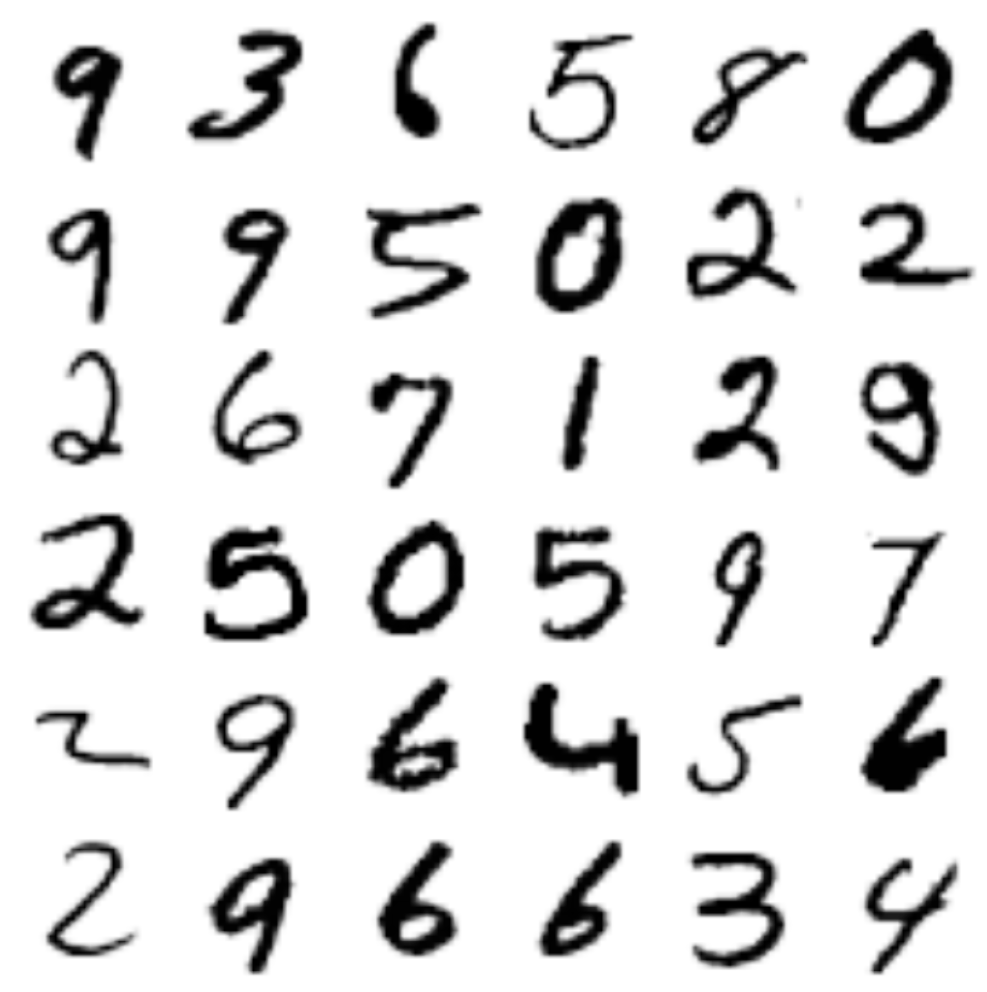

In [19]:
fig = plotImageTransp(mnist_digits, k = 6) 


Finally, we instantiate and train the model. Since the loss has been taken care of in our custom layer, we don't specify an external loss 
at compile time (`loss=None`), which in turns means that we won't pass target data during training (as you can see we only pass `x_train` 
to the model in `fit`).

In [20]:
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")
print(mnist_digits.shape)

(30000, 128, 128, 1)


In [21]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=16)

Epoch 1/30


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


1875/1875 [==============================] - 52s 24ms/step - loss: 214.6783 - reconstruction_loss: 214.6754 - kl_loss: 0.0029
Epoch 2/30
1875/1875 [==============================] - 46s 24ms/step - loss: 208.8906 - reconstruction_loss: 208.8730 - kl_loss: 0.0176
Epoch 3/30
1875/1875 [==============================] - 46s 24ms/step - loss: 208.7908 - reconstruction_loss: 208.7538 - kl_loss: 0.0370
Epoch 4/30
1875/1875 [==============================] - 46s 24ms/step - loss: 208.7750 - reconstruction_loss: 208.7325 - kl_loss: 0.0425
Epoch 5/30
1875/1875 [==============================] - 45s 24ms/step - loss: 208.7202 - reconstruction_loss: 208.6795 - kl_loss: 0.0408
Epoch 6/30
1875/1875 [==============================] - 46s 25ms/step - loss: 208.6532 - reconstruction_loss: 208.6174 - kl_loss: 0.0358
Epoch 7/30
1875/1875 [==============================] - 45s 24ms/step - loss: 208.6294 - reconstruction_loss: 208.5990 - kl_loss: 0.0304
Epoch 8/30
1875/1875 [==============================


Once such a model is trained -- e.g. on MNIST, in our case -- we can use the `decoder` network to turn arbitrary latent space vectors into 
images:

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


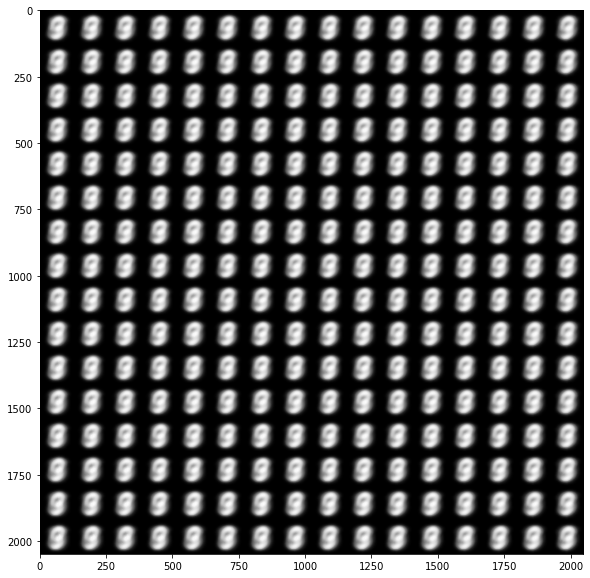

In [46]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 16  # figure with 15x15 digits
digit_size = 128
figure = np.zeros((digit_size * n, digit_size * n))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [47]:
x_decoded = np.squeeze(x_decoded)
x_decoded.shape

(16, 128, 128)

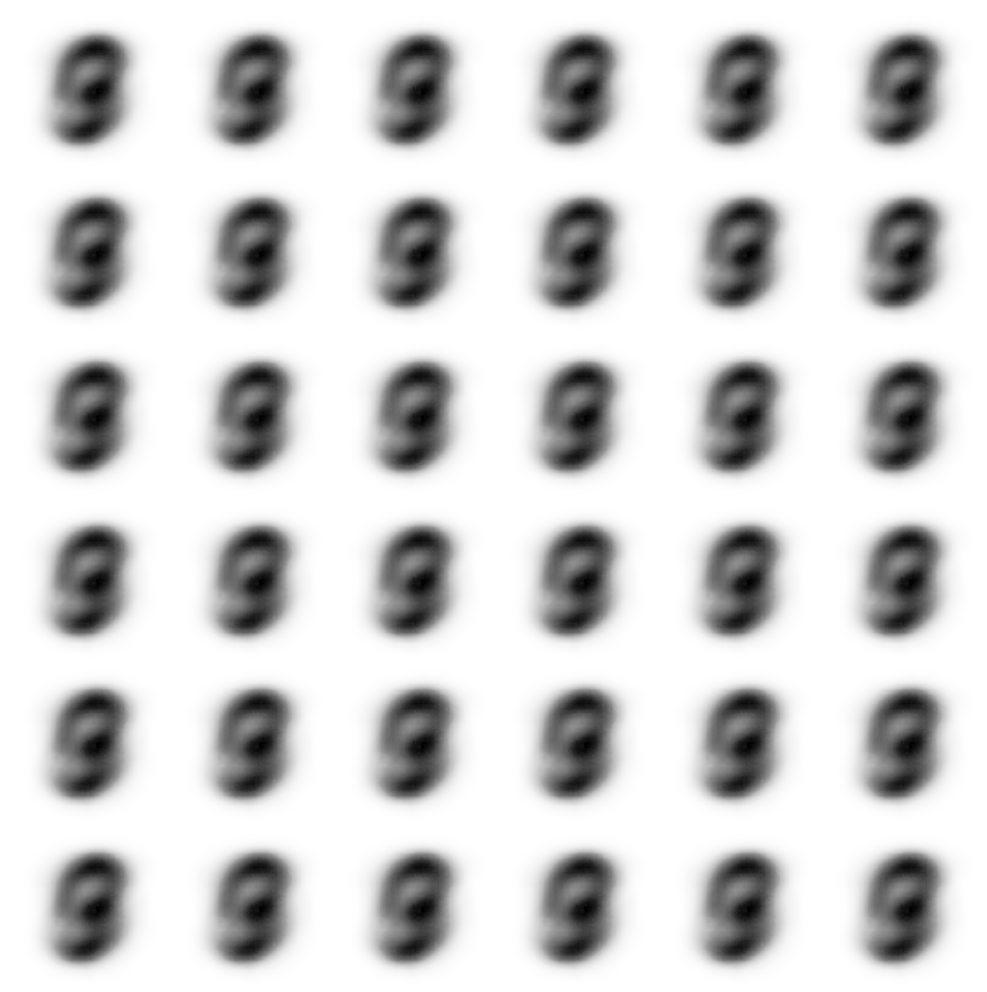

In [48]:
fig = plotImageTransp(x_decoded, k = 6) 

The grid of sampled digits shows a completely continuous distribution of the different digit classes, with one digit morphing into another 
as you follow a path through latent space. Specific directions in this space have a meaning, e.g. there is a direction for "four-ness", 
"one-ness", etc.